In [ ]:
!pip install snowflake-connector-python
!pip install pandasql
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 4.2.0
    Uninstalling platformdirs-4.2.0:
      Successfully uninstalled platformdirs-4.2.0
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=ef360ab182b6ca593b7d995520542238388861f5efa58fce0cad6d2371f75f3d
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [ ]:
import snowflake
import snowflake.connector
import pandas as pd
import numpy as np
import time
from pandasql import sqldf

pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import userdata

username=userdata.get('username')
password=userdata.get('password')

In [ ]:
ctx = snowflake.connector.connect(
 user = username,
 password = password,
 account = 'yb39416.eu-central-1',
 role = 'TEAM_1',
 current_warehouse = 'WH_TEAM1',
 database = 'TEAM_1',
 schema = 'PROD_DATA'
)

In [ ]:
cs = ctx.cursor()
try:
    cs.execute('SELECT CURRENT_WAREHOUSE()')
    one_row = cs.fetchone()
    print(one_row[0])
finally:
    cs.close()

WH_TEAM1


In [ ]:
def fetch_pandas_old(cur, sql):
    cur = ctx.cursor()
    cur.execute(sql)

    columns = list(map(lambda x : x.name, cur.description))
    rows = 0
    while True:
        dat = cur.fetchmany(600000) # fetching the data into set of 50 thousand rows
        if not dat:
            break

        if rows == 0: # concating the resulting dataframes
            df = pd.DataFrame(dat, columns=columns)
        else :
            tmp = pd.DataFrame(dat, columns=columns)
            df = pd.concat([df, tmp])
        rows += df.shape[0]
    cur.close()
    return df

In [ ]:
cust_sales_data =  fetch_pandas_old(ctx, """
                                       SELECT IDCUSTOMER,
                                              LAST_STORE_PURCHASED_COMMERCIAL_TYPE,
                                              LAST_STORE_PURCHASED_MANAGEMENT_TYPE,
                                              LAST_STORE_PURCHASED_GEOGRAPHICAL_AREA,
                                              LAST_STORE_PURCHASED_RETENTION_RATE,

                                              EMAIL_OPTIN_AND_REACHABLE,

                                              MOBILE_OPTIN_AND_REACHABLE,

                                              ORIGIN_COUNTRY,
                                              ORIGIN_STORE_GEOGRAPHICAL_AREA,

                                              CUSTOMER_SOURCE_CHANNEL,

                                              FIRST_TOUCH_POINT_SEASON_CODE,

                                             SECOND_TOUCH_POINT,
                                             LAST_TOUCH_POINT,

                                             b.season_code as LAST_TOUCH_POINT_SEASON_CODE,

                                             DAYS_FROM_FIRST_TO_SECOND,
                                             DAYS_FROM_FIRST_TO_LAST,

                                            MEN_ITEMS,
                                            WOMEN_ITEMS,

                                            SALE_COUNT,
                                            RETURN_COUNT,
                                            PROMO_COUNT,
                                            DISCOUNT_COUNT,

                                            AVG_PURCHASE_AMT,
                                            AVG_RETURN_AMT,
                                            AVG_DISCOUNT_AMT,

                                            TOTAL_PURCHASE_AMT,
                                            TOTAL_RETURN_AMT,
                                            TOTAL_DISCOUNT_AMT,

                                            NEXT_SEASON_PURCHASE,
                                            LAST_SEASON_PURCHASE,

                                            LAST_SEASON_SUMMER_FLAG,
                                            TEST_DATA_FLAG

                                            FROM TEAM_1.PROD_DATA.data_model_customer_data_version_3 as a

                                            left join

                                            (SELECT * FROM DATA_ACCESS.DATA_SOURCE.DIM_SEASON) B

                                            ON CAST(a.LAST_TOUCH_POINT AS DATE) <= B.SEASON_END_DATE and
                                               CAST(a.LAST_TOUCH_POINT AS DATE) >= B.SEASON_START_DATE
                                                                            """)

In [ ]:
cust_sales_data['TEST_DATA_FLAG'].value_counts()

0    553813
1    271529
Name: TEST_DATA_FLAG, dtype: int64

In [ ]:
display(cust_sales_data.head())

IDCUSTOMER LAST_STORE_PURCHASED_COMMERCIAL_TYPE  \
0  1-01002931841                              Digital   
1  1-00591002752                                  B&M   
2  1-01002675876                              Digital   
3  1-00020103455                                  B&M   
4  1-04191005358                                  B&M   

  LAST_STORE_PURCHASED_MANAGEMENT_TYPE LAST_STORE_PURCHASED_GEOGRAPHICAL_AREA  \
0                             INTERNET                                      -   
1                    DEPARTMENT STORES                                    IDF   
2                             INTERNET                                      -   
3                           AFFILIATES                            FR PROVINCE   
4                    DEPARTMENT STORES                                    IDF   

  LAST_STORE_PURCHASED_RETENTION_RATE  EMAIL_OPTIN_AND_REACHABLE  \
0                            0.000000                      False   
1                            0.000000                       True   
2                            0.000000                       True   
3                            0.000000                       True   
4                            0.000000                       True   

   MOBILE_OPTIN_AND_REACHABLE ORIGIN_COUNTRY ORIGIN_STORE_GEOGRAPHICAL_AREA  \
0                       False             FR                              -   
1                        True             FR                            IDF   
2                       False             FR                              -   
3                        True             FR                            IDF   
4                        True             FR                            IDF   

  CUSTOMER_SOURCE_CHANNEL FIRST_TOUCH_POINT_SEASON_CODE SECOND_TOUCH_POINT  \
0                   OTHER                           E22               None   
1                       -                           E20         2021-01-08   
2                   OTHER                           E22         2022-03-15   
3                       -                           E20         2020-06-08   
4                       -                           E21         2021-07-02   

  LAST_TOUCH_POINT LAST_TOUCH_POINT_SEASON_CODE  DAYS_FROM_FIRST_TO_SECOND  \
0       2022-07-13                          E22                          0   
1       2022-07-21                          E22                        231   
2       2022-06-29                          E22                          0   
3       2022-05-19                          E22                        112   
4       2022-05-21                          E22                         40   

   DAYS_FROM_FIRST_TO_LAST MEN_ITEMS WOMEN_ITEMS SALE_COUNT RETURN_COUNT  \
0                        0  0.000000    1.000000   1.000000     1.000000   
1                      790  2.000000    1.000000   3.000000         None   
2                      106  5.000000    2.000000   7.000000         None   
3                      822  9.000000    1.000000  10.000000     1.000000   
4                      363  1.000000    0.000000   1.000000         None   

   PROMO_COUNT  DISCOUNT_COUNT  AVG_PURCHASE_AMT     AVG_RETURN_AMT  \
0            0               2  110.000000000000  -110.000000000000   
1            1               1  108.600000000000              0E-12   
2            0               6   91.666666666667              0E-12   
3            0               0   92.909090909091   -10.454545454545   
4            0               0  195.000000000000              0E-12   

   AVG_DISCOUNT_AMT TOTAL_PURCHASE_AMT TOTAL_RETURN_AMT TOTAL_DISCOUNT_AMT  \
0             0E-12      220.000000000   -220.000000000               0E-9   
1    4.900000000000      325.800000000             0E-9       14.700000000   
2  164.166666666667      550.000000000             0E-9      985.000000000   
3             0E-12     1022.000000000   -115.000000000               0E-9   
4             0E-12      195.000000000             0E-9               0E-9   

 

In [ ]:
categorical_variables = ['LAST_STORE_PURCHASED_GEOGRAPHICAL_AREA',
                         'ORIGIN_STORE_GEOGRAPHICAL_AREA',
                         'FIRST_TOUCH_POINT_SEASON_CODE',
                         'CUSTOMER_SOURCE_CHANNEL'
                         ]

for var in categorical_variables:
    cust_sales_data[var] = cust_sales_data[var].replace("-", np.nan)

In [ ]:
cust_sales_data['LAST_STORE_PURCHASED_RETENTION_RATE'] = cust_sales_data['LAST_STORE_PURCHASED_RETENTION_RATE'].fillna(0).replace("None", 0)
cust_sales_data['RETURN_COUNT'] = cust_sales_data['RETURN_COUNT'].fillna(0).replace("None", 0)

cust_sales_data['EMAIL_OPTIN_AND_REACHABLE'] = cust_sales_data['EMAIL_OPTIN_AND_REACHABLE'].map({True: 1, False: 0}).fillna(0).replace('NaN', 0)
cust_sales_data['MOBILE_OPTIN_AND_REACHABLE'] = cust_sales_data['MOBILE_OPTIN_AND_REACHABLE'].map({True: 1, False: 0}).fillna(0).replace('NaN', 0)

cust_sales_data['DAYS_FROM_FIRST_TO_SECOND'] = cust_sales_data['DAYS_FROM_FIRST_TO_SECOND'].fillna( 0)
cust_sales_data['DAYS_FROM_FIRST_TO_LAST'] = cust_sales_data['DAYS_FROM_FIRST_TO_LAST'].fillna(0)


# Create a new column 'ORIGIN_COUNTRY_ENCODED' based on conditions
cust_sales_data['ORIGIN_COUNTRY_ENCODED'] = cust_sales_data['ORIGIN_COUNTRY'].apply(lambda x: x if x in ['FR', 'GB'] else 'Other_countries')

plot_data = cust_sales_data[(cust_sales_data['TEST_DATA_FLAG'] == 0) & (cust_sales_data['LAST_SEASON_SUMMER_FLAG'] == 1)]
plot_data.head()

IDCUSTOMER LAST_STORE_PURCHASED_COMMERCIAL_TYPE  \
0  1-01002931841                              Digital   
1  1-00591002752                                  B&M   
2  1-01002675876                              Digital   
3  1-00020103455                                  B&M   
4  1-04191005358                                  B&M   

  LAST_STORE_PURCHASED_MANAGEMENT_TYPE LAST_STORE_PURCHASED_GEOGRAPHICAL_AREA  \
0                             INTERNET                                    NaN   
1                    DEPARTMENT STORES                                    IDF   
2                             INTERNET                                    NaN   
3                           AFFILIATES                            FR PROVINCE   
4                    DEPARTMENT STORES                                    IDF   

  LAST_STORE_PURCHASED_RETENTION_RATE  EMAIL_OPTIN_AND_REACHABLE  \
0                            0.000000                          0   
1                            0.000000                          1   
2                            0.000000                          1   
3                            0.000000                          1   
4                            0.000000                          1   

   MOBILE_OPTIN_AND_REACHABLE ORIGIN_COUNTRY ORIGIN_STORE_GEOGRAPHICAL_AREA  \
0                           0             FR                            NaN   
1                           1             FR                            IDF   
2                           0             FR                            NaN   
3                           1             FR                            IDF   
4                           1             FR                            IDF   

  CUSTOMER_SOURCE_CHANNEL FIRST_TOUCH_POINT_SEASON_CODE SECOND_TOUCH_POINT  \
0                   OTHER                           E22               None   
1                     NaN                           E20         2021-01-08   
2                   OTHER                           E22         2022-03-15   
3                     NaN                           E20         2020-06-08   
4                     NaN                           E21         2021-07-02   

  LAST_TOUCH_POINT LAST_TOUCH_POINT_SEASON_CODE  DAYS_FROM_FIRST_TO_SECOND  \
0       2022-07-13                          E22                          0   
1       2022-07-21                          E22                        231   
2       2022-06-29                          E22                          0   
3       2022-05-19                          E22                        112   
4       2022-05-21                          E22                         40   

   DAYS_FROM_FIRST_TO_LAST MEN_ITEMS WOMEN_ITEMS SALE_COUNT RETURN_COUNT  \
0                        0  0.000000    1.000000   1.000000     1.000000   
1                      790  2.000000    1.000000   3.000000            0   
2                      106  5.000000    2.000000   7.000000            0   
3                      822  9.000000    1.000000  10.000000     1.000000   
4                      363  1.000000    0.000000   1.000000            0   

   PROMO_COUNT  DISCOUNT_COUNT  AVG_PURCHASE_AMT     AVG_RETURN_AMT  \
0            0               2  110.000000000000  -110.000000000000   
1            1               1  108.600000000000              0E-12   
2            0               6   91.666666666667              0E-12   
3            0               0   92.909090909091   -10.454545454545   
4            0               0  195.000000000000              0E-12   

   AVG_DISCOUNT_AMT TOTAL_PURCHASE_AMT TOTAL_RETURN_AMT TOTAL_DISCOUNT_AMT  \
0             0E-12      220.000000000   -220.000000000               0E-9   
1    4.900000000000      325.800000000             0E-9       14.700000000   
2  164.166666666667      550.000000000             0E-9      985.000000000   
3             0E-12     1022.000000000   -115.000000000               0E-9   
4             0E-12      195.000000000             0E-9               0E-9   

 

In [ ]:
categorical_variables = ['LAST_STORE_PURCHASED_COMMERCIAL_TYPE',
                         'LAST_STORE_PURCHASED_MANAGEMENT_TYPE',
                         'LAST_STORE_PURCHASED_GEOGRAPHICAL_AREA',
                         'ORIGIN_COUNTRY_ENCODED',
                         'ORIGIN_STORE_GEOGRAPHICAL_AREA',
                         'FIRST_TOUCH_POINT_SEASON_CODE',
                         'LAST_TOUCH_POINT_SEASON_CODE',
                         'CUSTOMER_SOURCE_CHANNEL'
                         ]

## ONE HOT ENCODE THE COLUMNS WITH CATEGORICAL VARIABLES
cust_sales_data= pd.get_dummies(cust_sales_data, columns=categorical_variables, dummy_na=False)

In [ ]:
cust_sales_data = cust_sales_data.drop(columns=['ORIGIN_COUNTRY', 'SECOND_TOUCH_POINT', 'LAST_TOUCH_POINT'], inplace=False)

In [ ]:
display(cust_sales_data.head())

IDCUSTOMER LAST_STORE_PURCHASED_RETENTION_RATE  \
0  1-01002931841                            0.000000   
1  1-00591002752                            0.000000   
2  1-01002675876                            0.000000   
3  1-00020103455                            0.000000   
4  1-04191005358                            0.000000   

   EMAIL_OPTIN_AND_REACHABLE  MOBILE_OPTIN_AND_REACHABLE  \
0                          0                           0   
1                          1                           1   
2                          1                           0   
3                          1                           1   
4                          1                           1   

   DAYS_FROM_FIRST_TO_SECOND  DAYS_FROM_FIRST_TO_LAST MEN_ITEMS WOMEN_ITEMS  \
0                          0                        0  0.000000    1.000000   
1                        231                      790  2.000000    1.000000   
2                          0                      106  5.000000    2.000000   
3                        112                      822  9.000000    1.000000   
4                         40                      363  1.000000    0.000000   

  SALE_COUNT RETURN_COUNT  PROMO_COUNT  DISCOUNT_COUNT  AVG_PURCHASE_AMT  \
0   1.000000     1.000000            0               2  110.000000000000   
1   3.000000            0            1               1  108.600000000000   
2   7.000000            0            0               6   91.666666666667   
3  10.000000     1.000000            0               0   92.909090909091   
4   1.000000            0            0               0  195.000000000000   

      AVG_RETURN_AMT  AVG_DISCOUNT_AMT TOTAL_PURCHASE_AMT TOTAL_RETURN_AMT  \
0  -110.000000000000             0E-12      220.000000000   -220.000000000   
1              0E-12    4.900000000000      325.800000000             0E-9   
2              0E-12  164.166666666667      550.000000000             0E-9   
3   -10.454545454545             0E-12     1022.000000000   -115.000000000   
4              0E-12             0E-12      195.000000000             0E-9   

  TOTAL_DISCOUNT_AMT NEXT_SEASON_PURCHASE LAST_SEASON_PURCHASE  \
0               0E-9                    0                    1   
1       14.700000000                    1                    1   
2      985.000000000                    0                    1   
3               0E-9                    1                    1   
4               0E-9                    0                    1   

   LAST_SEASON_SUMMER_FLAG  TEST_DATA_FLAG  \
0                        1               0   
1                        1               0   
2                        1               0   
3                        1               0   
4                        1               0   

   LAST_STORE_PURCHASED_COMMERCIAL_TYPE_B&M  \
0                                         0   
1                                         1   
2                                         0   
3                                         1   
4                                         1   

   LAST_STORE_PURCHASED_COMMERCIAL_TYPE_Digital  \
0                                             1   
1                                             0   
2                                             1   
3                                             0   
4                                             0   

   LAST_STORE_PURCHASED_MANAGEMENT_TYPE_AFFILIATES  \
0                                                0   
1                                                0   
2                                                0   
3                                                1   
4                                                0   

   LAST_STORE_PURCHASED_MANAGEMENT_TYPE_BRANCHES  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   LA

## Final Train and Test Data

In [ ]:
## for train and test data, change the days_to_second_purchase and days_to_last_purchase  = 0 if the date exceeds E23 and H23 respectively

In [ ]:
final_data_columns = ['IDCUSTOMER',
                        'LAST_STORE_PURCHASED_RETENTION_RATE',

                        'EMAIL_OPTIN_AND_REACHABLE',
                        'MOBILE_OPTIN_AND_REACHABLE',
                        'DAYS_FROM_FIRST_TO_SECOND',
                        'DAYS_FROM_FIRST_TO_LAST',
                        'MEN_ITEMS',
                        'WOMEN_ITEMS',

                        'SALE_COUNT',
                        'RETURN_COUNT',
                        'DISCOUNT_COUNT',

                        'AVG_PURCHASE_AMT',
                        'AVG_RETURN_AMT',
                        'AVG_DISCOUNT_AMT',

                        'TOTAL_PURCHASE_AMT',
                        'TOTAL_RETURN_AMT',
                        'TOTAL_DISCOUNT_AMT',
                        'LAST_SEASON_PURCHASE',

                        'LAST_SEASON_SUMMER_FLAG',

                        'LAST_STORE_PURCHASED_COMMERCIAL_TYPE_B&M',
                        'LAST_STORE_PURCHASED_COMMERCIAL_TYPE_Digital',
                        'LAST_STORE_PURCHASED_MANAGEMENT_TYPE_AFFILIATES',
                        'LAST_STORE_PURCHASED_MANAGEMENT_TYPE_BRANCHES',
                        'LAST_STORE_PURCHASED_MANAGEMENT_TYPE_DEPARTMENT STORES',
                        'LAST_STORE_PURCHASED_MANAGEMENT_TYPE_INTERNET',


                        'LAST_STORE_PURCHASED_GEOGRAPHICAL_AREA_FR PROVINCE',
                        'LAST_STORE_PURCHASED_GEOGRAPHICAL_AREA_GB PROVINCE',
                        'LAST_STORE_PURCHASED_GEOGRAPHICAL_AREA_IDF',
                        'LAST_STORE_PURCHASED_GEOGRAPHICAL_AREA_LONDON',

                        'ORIGIN_COUNTRY_ENCODED_FR',
                        'ORIGIN_COUNTRY_ENCODED_GB',
                        'ORIGIN_COUNTRY_ENCODED_Other_countries',

                        'ORIGIN_STORE_GEOGRAPHICAL_AREA_FR_PROVINCE',
                        'ORIGIN_STORE_GEOGRAPHICAL_AREA_GB_PROVINCE',
                        'ORIGIN_STORE_GEOGRAPHICAL_AREA_IDF',
                        'ORIGIN_STORE_GEOGRAPHICAL_AREA_LONDON',

                        'FIRST_TOUCH_POINT_SEASON_CODE_E20',
                        'FIRST_TOUCH_POINT_SEASON_CODE_E21',
                        'FIRST_TOUCH_POINT_SEASON_CODE_E22',
                        'FIRST_TOUCH_POINT_SEASON_CODE_H20',
                        'FIRST_TOUCH_POINT_SEASON_CODE_H21',
                        'FIRST_TOUCH_POINT_SEASON_CODE_H22',

                        'LAST_TOUCH_POINT_SEASON_CODE_E20',
                        'LAST_TOUCH_POINT_SEASON_CODE_E21',
                        'LAST_TOUCH_POINT_SEASON_CODE_E22',
                        'LAST_TOUCH_POINT_SEASON_CODE_E23',
                        'LAST_TOUCH_POINT_SEASON_CODE_H20',
                        'LAST_TOUCH_POINT_SEASON_CODE_H21',
                        'LAST_TOUCH_POINT_SEASON_CODE_H22',

                        'CUSTOMER_SOURCE_CHANNEL_INTERNET',
                        'CUSTOMER_SOURCE_CHANNEL_OTHER',
                        'CUSTOMER_SOURCE_CHANNEL_SRC',
                        'CUSTOMER_SOURCE_CHANNEL_STORE']

In [ ]:
cust_sales_data['TEST_DATA_FLAG'].value_counts()

0    553813
1    271529
Name: TEST_DATA_FLAG, dtype: int64

In [ ]:
train_x_data = cust_sales_data[cust_sales_data['TEST_DATA_FLAG']==0][final_data_columns]
len(train_x_data)

553813

In [ ]:
test_x_data = cust_sales_data[cust_sales_data['TEST_DATA_FLAG']==1][final_data_columns]
len(test_x_data)

271529

In [ ]:
train_x_data = train_x_data.set_index('IDCUSTOMER')
test_x_data = test_x_data.set_index('IDCUSTOMER')

In [ ]:
columns = pd.concat([pd.DataFrame(train_x_data.columns, columns=['train_data']),
                   pd.DataFrame(test_x_data.columns, columns=['test_data'])
                   ], axis=1)

display(columns[columns['train_data']!=columns['test_data']])

Empty DataFrame
Columns: [train_data, test_data]
Index: []

In [ ]:
display(train_x_data.head())

LAST_STORE_PURCHASED_RETENTION_RATE  EMAIL_OPTIN_AND_REACHABLE  \
IDCUSTOMER                                                                     
1-01002931841                            0.000000                          0   
1-00591002752                            0.000000                          1   
1-01002675876                            0.000000                          1   
1-00020103455                            0.000000                          1   
1-04191005358                            0.000000                          1   

               MOBILE_OPTIN_AND_REACHABLE  DAYS_FROM_FIRST_TO_SECOND  \
IDCUSTOMER                                                             
1-01002931841                           0                          0   
1-00591002752                           1                        231   
1-01002675876                           0                          0   
1-00020103455                           1                        112   
1-04191005358                           1                         40   

               DAYS_FROM_FIRST_TO_LAST MEN_ITEMS WOMEN_ITEMS SALE_COUNT  \
IDCUSTOMER                                                                
1-01002931841                        0  0.000000    1.000000   1.000000   
1-00591002752                      790  2.000000    1.000000   3.000000   
1-01002675876                      106  5.000000    2.000000   7.000000   
1-00020103455                      822  9.000000    1.000000  10.000000   
1-04191005358                      363  1.000000    0.000000   1.000000   

              RETURN_COUNT  DISCOUNT_COUNT  AVG_PURCHASE_AMT  \
IDCUSTOMER                                                     
1-01002931841     1.000000               2  110.000000000000   
1-00591002752            0               1  108.600000000000   
1-01002675876            0               6   91.666666666667   
1-00020103455     1.000000               0   92.909090909091   
1-04191005358            0               0  195.000000000000   

                  AVG_RETURN_AMT  AVG_DISCOUNT_AMT TOTAL_PURCHASE_AMT  \
IDCUSTOMER                                                              
1-01002931841  -110.000000000000             0E-12      220.000000000   
1-00591002752              0E-12    4.900000000000      325.800000000   
1-01002675876              0E-12  164.166666666667      550.000000000   
1-00020103455   -10.454545454545             0E-12     1022.000000000   
1-04191005358              0E-12             0E-12      195.000000000   

              TOTAL_RETURN_AMT TOTAL_DISCOUNT_AMT LAST_SEASON_PURCHASE  \
IDCUSTOMER                                                               
1-01002931841   -220.000000000               0E-9                    1   
1-00591002752             0E-9       14.700000000                    1   
1-01002675876             0E-9      985.000000000                    1   
1-00020103455   -115.000000000               0E-9                    1   
1-04191005358             0E-9               0E-9                    1   

               LAST_SEASON_SUMMER_FLAG  \
IDCUSTOMER                               
1-01002931841                        1   
1-00591002752                        1   
1-01002675876                        1   
1-00020103455                        1   
1-04191005358                        1   

               LAST_STORE_PURCHASED_COMMERCIAL_TYPE_B&M  \
IDCUSTOMER                                                
1-01002931841                                         0   
1-00591002752                                         1   
1-01002675876                                         0   
1-00020103455                                         1   
1-04191005358                                         1   

               LAST_STORE_PURCHASED_COMMERCIAL_TYPE_Digital  \
IDCUSTOMER                                                    
1-01002931841                                             1   
1-00591002752                               

In [ ]:
train_y = cust_sales_data[cust_sales_data['TEST_DATA_FLAG']==0]['NEXT_SEASON_PURCHASE'].ravel().astype(int)
test_y = cust_sales_data[cust_sales_data['TEST_DATA_FLAG']==1]['NEXT_SEASON_PURCHASE'].ravel().astype(int)

In [ ]:
scaled_train_x_data = train_x_data.astype(float).copy()
scaled_test_x_data = test_x_data.astype(float).copy()

In [ ]:
train_y = np.asarray(train_y).astype('int')
test_y = np.asarray(test_y).astype('int')

In [ ]:
display(scaled_train_x_data.head())

LAST_STORE_PURCHASED_RETENTION_RATE  EMAIL_OPTIN_AND_REACHABLE  \
IDCUSTOMER                                                                      
1-01002931841                                  0.0                        0.0   
1-00591002752                                  0.0                        1.0   
1-01002675876                                  0.0                        1.0   
1-00020103455                                  0.0                        1.0   
1-04191005358                                  0.0                        1.0   

               MOBILE_OPTIN_AND_REACHABLE  DAYS_FROM_FIRST_TO_SECOND  \
IDCUSTOMER                                                             
1-01002931841                         0.0                        0.0   
1-00591002752                         1.0                      231.0   
1-01002675876                         0.0                        0.0   
1-00020103455                         1.0                      112.0   
1-04191005358                         1.0                       40.0   

               DAYS_FROM_FIRST_TO_LAST  MEN_ITEMS  WOMEN_ITEMS  SALE_COUNT  \
IDCUSTOMER                                                                   
1-01002931841                      0.0        0.0          1.0         1.0   
1-00591002752                    790.0        2.0          1.0         3.0   
1-01002675876                    106.0        5.0          2.0         7.0   
1-00020103455                    822.0        9.0          1.0        10.0   
1-04191005358                    363.0        1.0          0.0         1.0   

               RETURN_COUNT  DISCOUNT_COUNT  AVG_PURCHASE_AMT  AVG_RETURN_AMT  \
IDCUSTOMER                                                                      
1-01002931841           1.0             2.0        110.000000     -110.000000   
1-00591002752           0.0             1.0        108.600000        0.000000   
1-01002675876           0.0             6.0         91.666667        0.000000   
1-00020103455           1.0             0.0         92.909091      -10.454545   
1-04191005358           0.0             0.0        195.000000        0.000000   

               AVG_DISCOUNT_AMT  TOTAL_PURCHASE_AMT  TOTAL_RETURN_AMT  \
IDCUSTOMER                                                              
1-01002931841          0.000000               220.0            -220.0   
1-00591002752          4.900000               325.8               0.0   
1-01002675876        164.166667               550.0               0.0   
1-00020103455          0.000000              1022.0            -115.0   
1-04191005358          0.000000               195.0               0.0   

               TOTAL_DISCOUNT_AMT  LAST_SEASON_PURCHASE  \
IDCUSTOMER                                                
1-01002931841                 0.0                   1.0   
1-00591002752                14.7                   1.0   
1-01002675876               985.0                   1.0   
1-00020103455                 0.0                   1.0   
1-04191005358                 0.0                   1.0   

               LAST_SEASON_SUMMER_FLAG  \
IDCUSTOMER                               
1-01002931841                      1.0   
1-00591002752                      1.0   
1-01002675876                      1.0   
1-00020103455                      1.0   
1-04191005358                      1.0   

               LAST_STORE_PURCHASED_COMMERCIAL_TYPE_B&M  \
IDCUSTOMER                                                
1-01002931841                                       0.0   
1-00591002752                                       1.0   
1-01002675876                                       0.0   
1-00020103455                                       1.0   
1-04191005358                                       1.0   

               LAST_STORE_PURCHASED_COMMERCIAL_TYPE_Digital  \
IDCUSTOMER                                                    
1-01002931841                                           1.0   
1-0

## Feature Selection

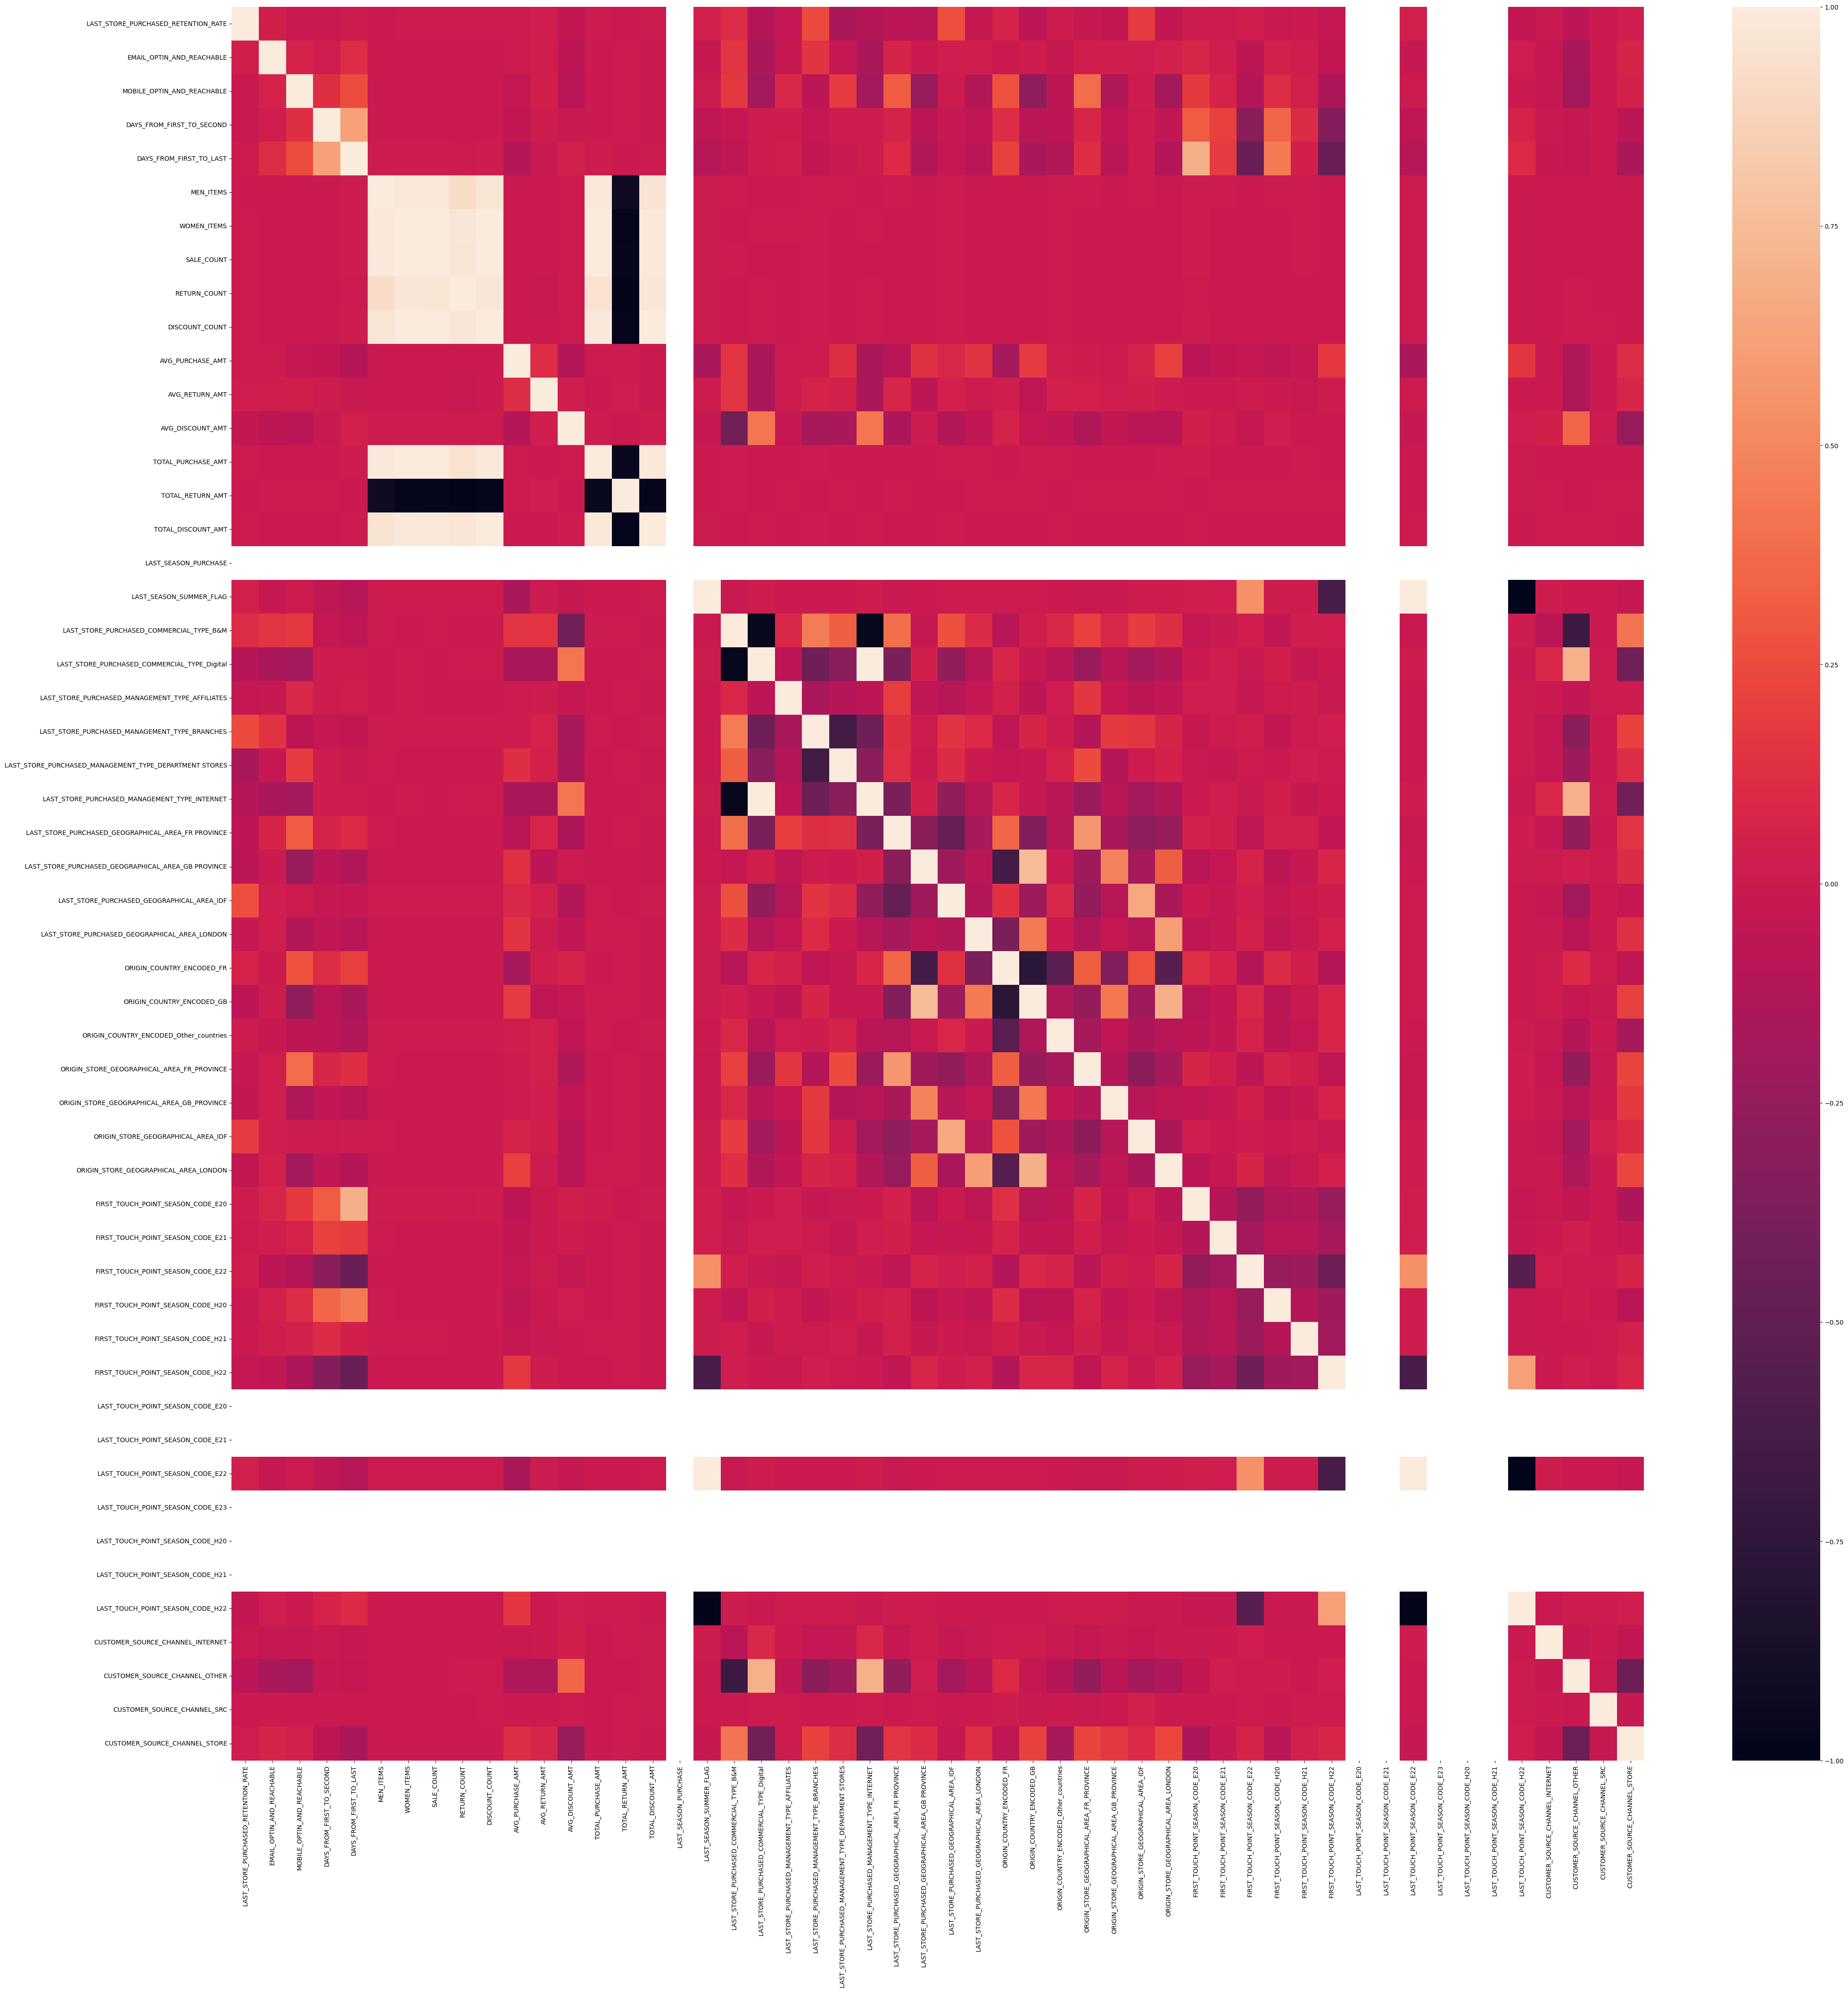

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = scaled_train_x_data.corr()

# plot the heatmap
plt.figure(figsize=(50,50))
sns.heatmap(corr)
plt.show()

#plt.savefig('correlation_heatmap.png')

In [ ]:
drop_variables = [

                    'LAST_TOUCH_POINT_SEASON_CODE_E20',
                    'LAST_TOUCH_POINT_SEASON_CODE_E21',
                    'LAST_TOUCH_POINT_SEASON_CODE_E23',
                    'LAST_TOUCH_POINT_SEASON_CODE_H20',
                    'LAST_TOUCH_POINT_SEASON_CODE_H21',
                    'LAST_SEASON_PURCHASE',
                    'WOMEN_ITEMS',
                    'RETURN_COUNT',
                    'DISCOUNT_COUNT',
                    'TOTAL_RETURN_AMT',
                    'TOTAL_DISCOUNT_AMT',

                  ]

upd_scaled_train_x_data = scaled_train_x_data.drop(columns=drop_variables)
#upd_scaled_train_x_data = upd_scaled_train_x_data[upd_scaled_train_x_data['GENDER_Company']==0]
upd_scaled_test_x_data = scaled_test_x_data.drop(columns=drop_variables)
#upd_scaled_test_x_data = upd_scaled_test_x_data[upd_scaled_test_x_data['GENDER_Company']==0]

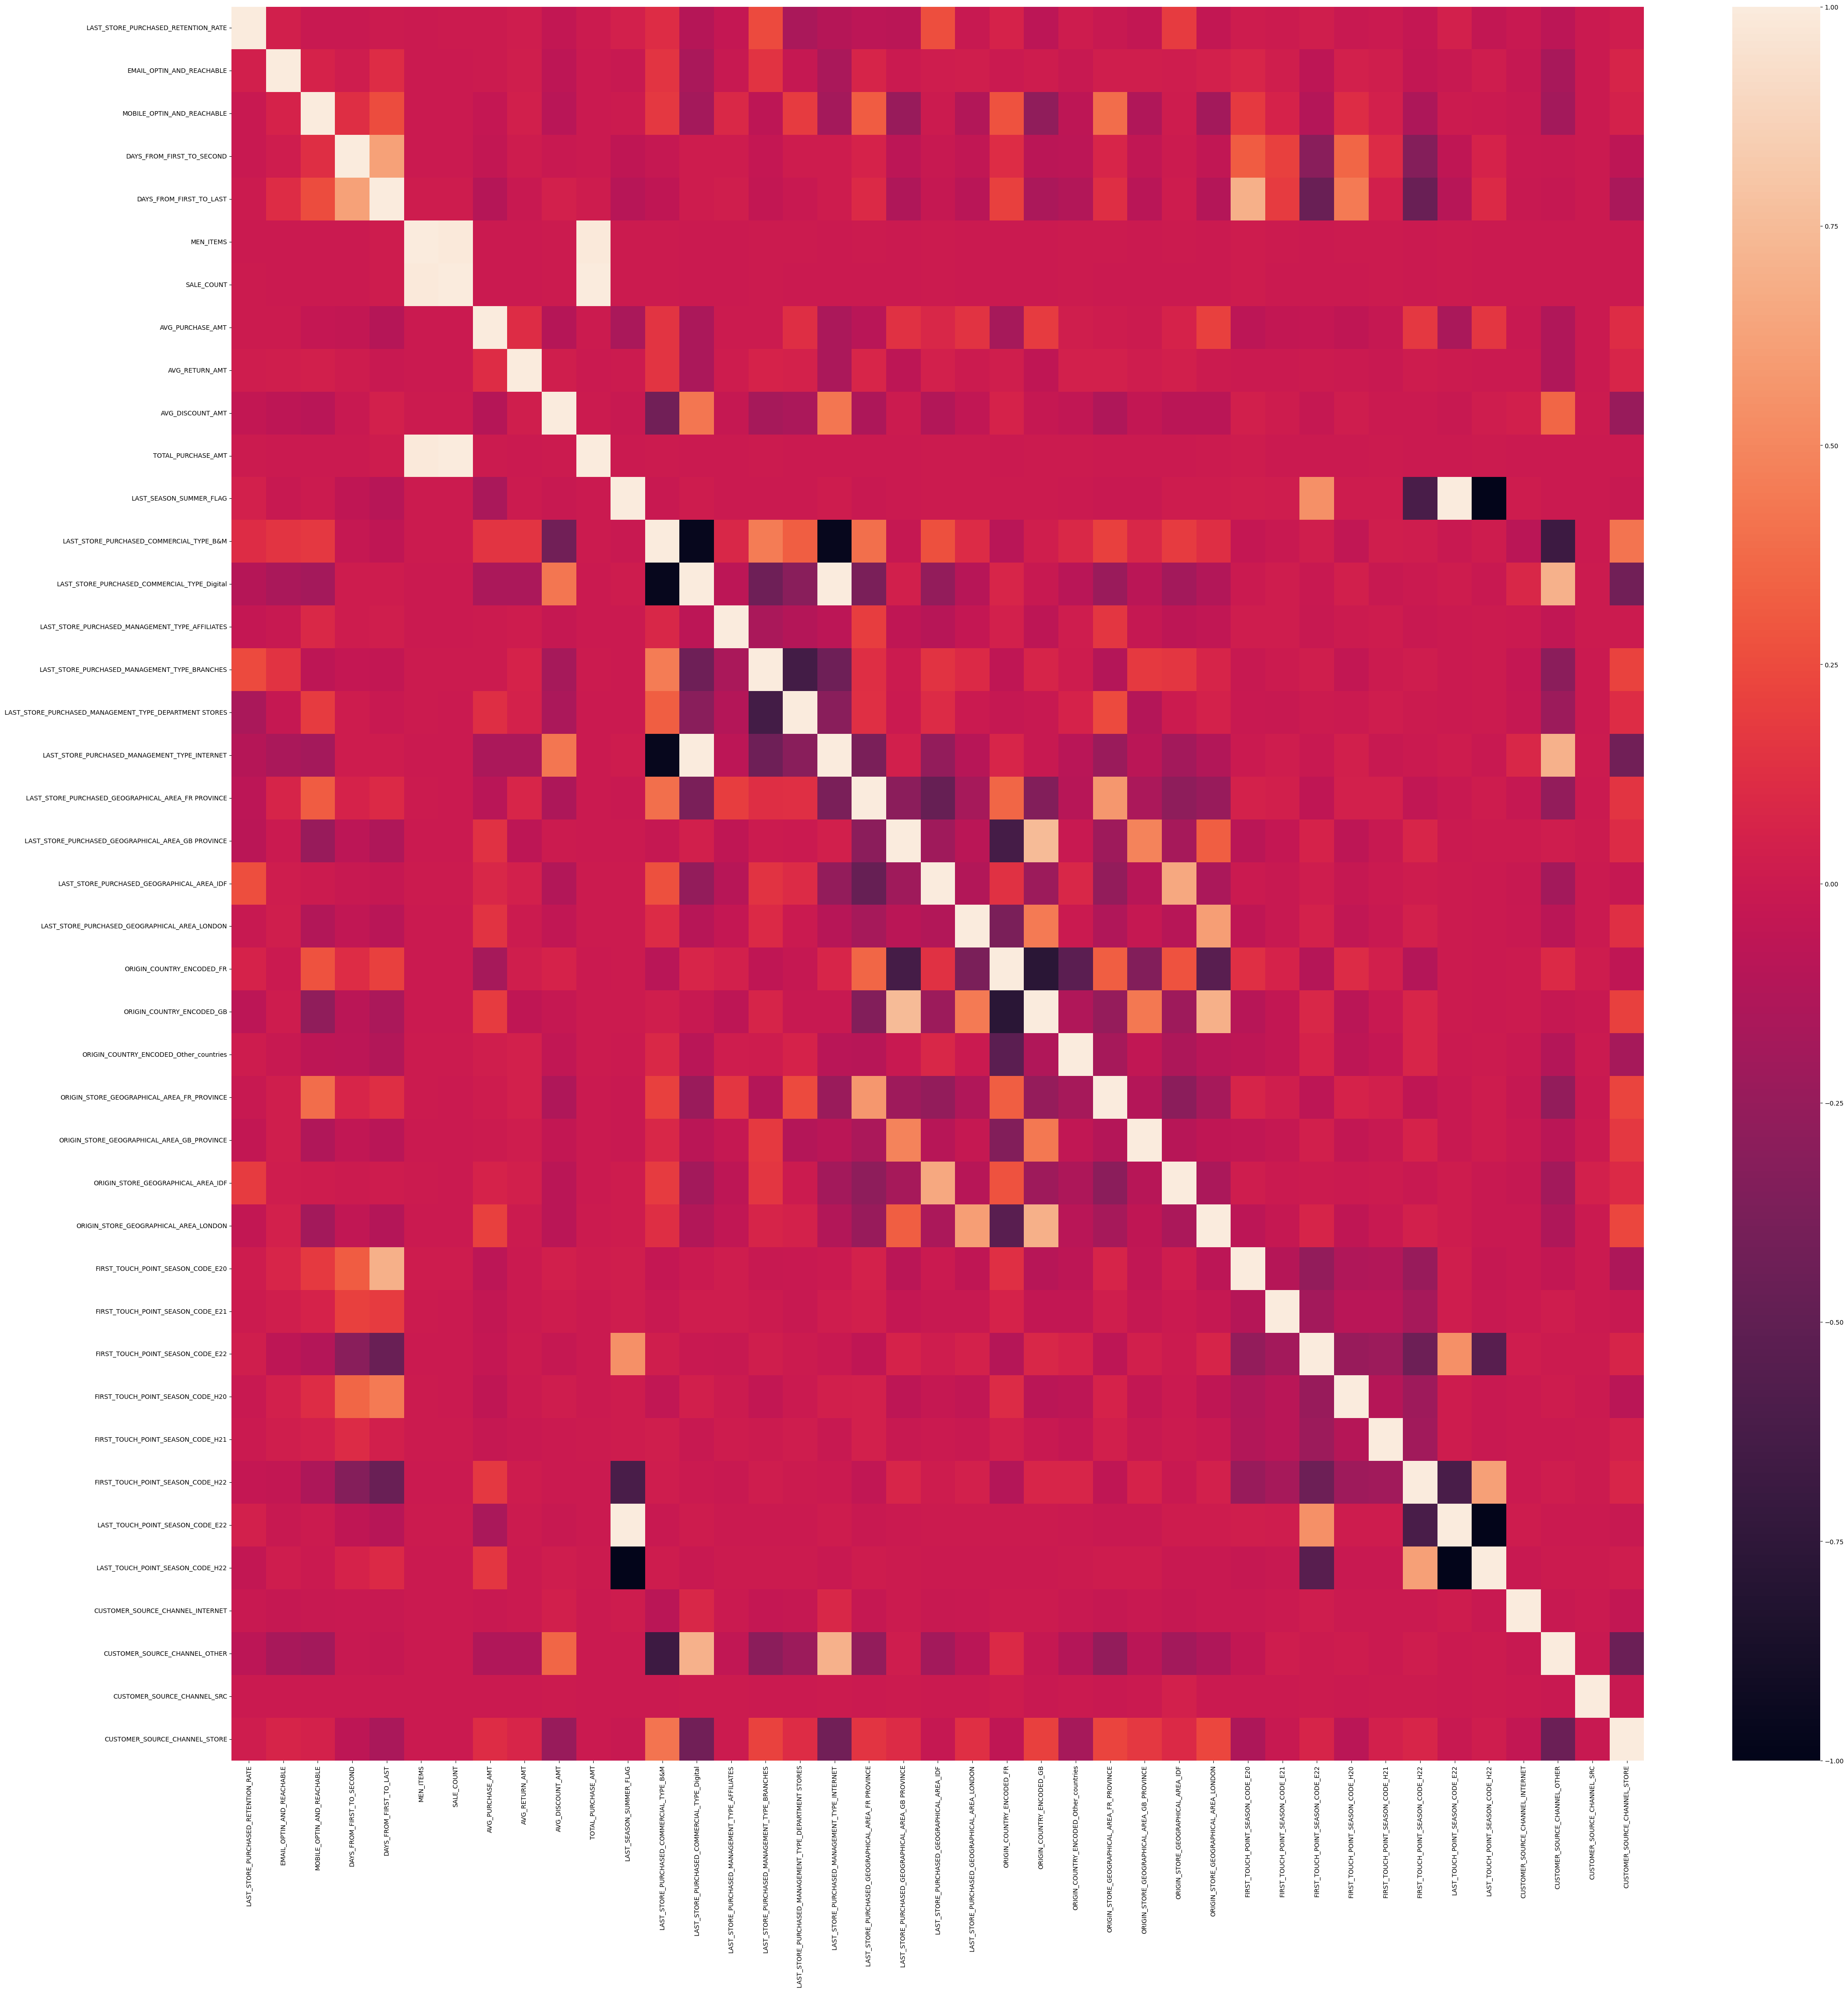

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = upd_scaled_train_x_data.corr()

# plot the heatmap
plt.figure(figsize=(50,50))
sns.heatmap(corr)
plt.show()

#plt.savefig('correlation_heatmap.png')

## Model Training

#### XGBoost

XGBoost, short for eXtreme Gradient Boosting, is a powerful tool used in data-driven decision-making. It's like having a smart assistant for making predictions and solving problems.

Ensemble Learning: XGBoost combines the opinions of multiple "experts" (weak models) to make a final decision. Each expert is good at certain aspects, and together they create a stronger, more accurate model.

Learning from Mistakes: XGBoost learns from its mistakes. If it makes an incorrect prediction, it figures out why and adjusts its strategy to avoid similar errors in the future. This constant learning helps improve accuracy over time.

Feature Importance: It tells us which factors (features) are the most important in making decisions. This is valuable information for businesses to understand what really drives success or failure in a particular scenario.

Flexibility: XGBoost can be used for various tasks, such as predicting customer behavior, optimizing marketing strategies, or identifying fraudulent activities. It's like a versatile tool that adapts to different challenges.

Efficiency: XGBoost is efficient and works quickly, even with large amounts of data. This speed allows businesses to get insights and make decisions faster.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have a feature matrix X and target variable y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric='auc', random_state=42)

# Fit the GridSearchCV object to the data
xgb_model.fit(upd_scaled_train_x_data, train_y)

# Make predictions on the test set
y_pred = xgb_model.predict(upd_scaled_test_x_data)
y_pred_prob = xgb_model.predict_proba(upd_scaled_test_x_data)[:, 1]

# Evaluate the model
accuracy = accuracy_score(test_y, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7839383638580041


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87    217236
           1       0.45      0.37      0.41     54293

    accuracy                           0.78    271529
   macro avg       0.65      0.63      0.64    271529
weighted avg       0.77      0.78      0.78    271529



In [ ]:
y_pred_adjusted = (y_pred_prob > 0.4).astype(int)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_y, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84    217236
           1       0.41      0.49      0.45     54293

    accuracy                           0.76    271529
   macro avg       0.64      0.66      0.64    271529
weighted avg       0.77      0.76      0.76    271529



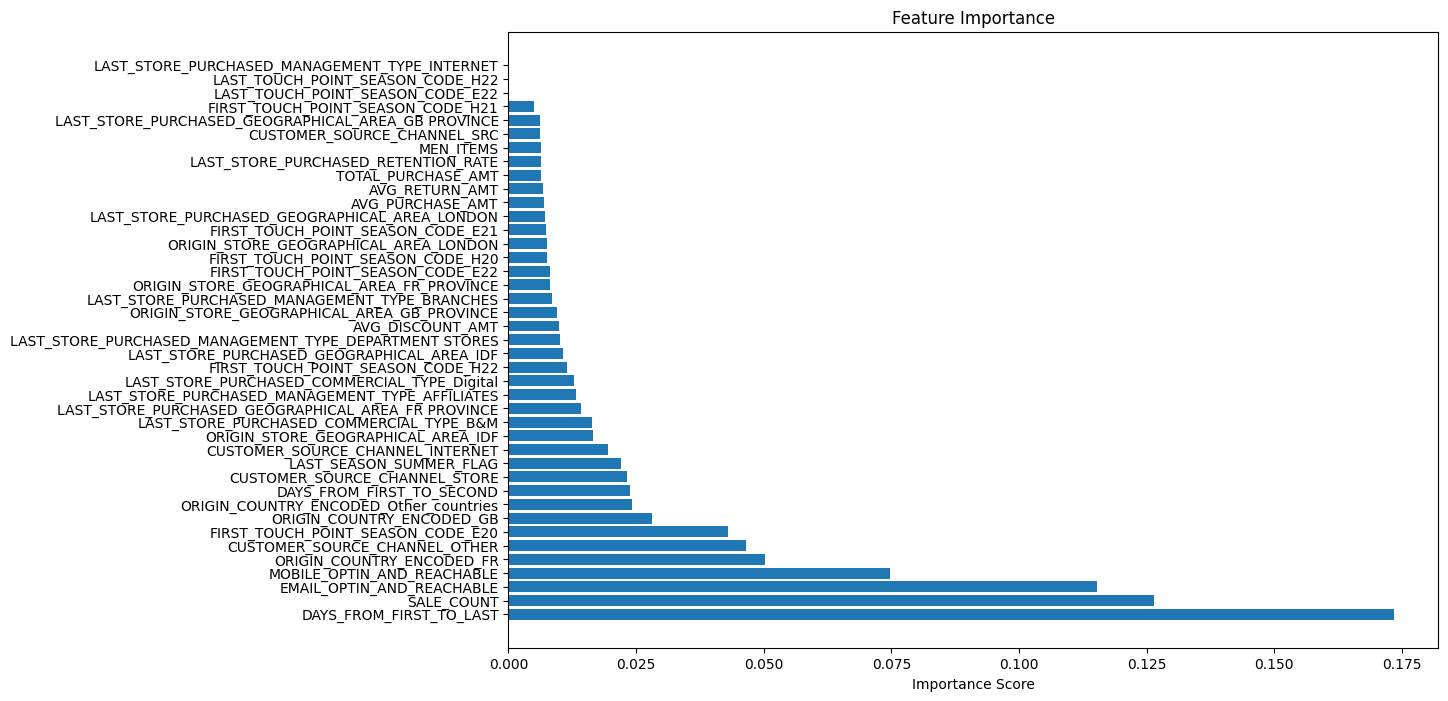

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming you have a trained XGBoost model named 'xgb_model' and your data in 'X_train'

# Train your XGBoost model (if not already trained)
# xgb_model.fit(X_train, y_train)

# Get feature importance scores
feature_importance = xgb_model.feature_importances_

# Get the names of the features
feature_names = upd_scaled_train_x_data.columns

# Create a dataframe to store feature names and their corresponding importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the dataframe by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.show()


In [ ]:
import dtreeviz

viz_model = dtreeviz.model(xgb_model, tree_index=1,
                           X_train=upd_scaled_train_x_data, y_train=train_y,
                           feature_names=list(upd_scaled_train_x_data.columns),
                           target_name='NEXT_SEASON_PURCHASE', class_names=["Churned", "Not Churned"])

In [ ]:
viz_model.view(fontname="monospace")

In [ ]:
viz_model.view(fontname="monospace", show_just_path=True)

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_y, y_pred_adjusted)

# Extract individual values from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print individual values
print("\nTrue Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)


Confusion Matrix:
[[178463  38773]
 [ 27627  26666]]

True Negatives (TN): 178463
False Positives (FP): 38773
False Negatives (FN): 27627
True Positives (TP): 26666
